In [1]:
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm
from typing import List
import time

sys.path.append("../")

from RGS_test import *
from RGS import *
from data_generator import *
from data_plotting import *

In [2]:
# # Set random seed for reproducibility 
# rng = np.random.default_rng(42)

# # Generate synthetic data 
# n_samples = 1000
# n_features = 20
# k_true = 3  # Only first 3 features are relevant

# # Generate features - now in sklearn convention (n_samples, n_features)
# X = rng.standard_normal((n_samples, n_features))

# # Generate target with only first k_true features being relevant
# true_coef = np.zeros(n_features)
# true_coef[:k_true] = [1.0, 0.5, 0.25]  # Decreasing importance
# noise = rng.standard_normal(n_samples) * 0.1
# y = X @ true_coef + noise

# # Initialize model
# k_max = 10
# m_grid = [1, 3, 5, 10, 15, 20]
# cv = KFold(n_splits=5, shuffle=True, random_state=42)
# model = RGSCV(
#     k_max=k_max,
#     m_grid=m_grid,
#     n_estimators=1000,
#     random_state=42,
#     cv=cv
# )

# # Fit model
# model.fit(X, y)

# # Print results
# print("True coefficients:", true_coef)
# print("\nSelected k:", model.k_)
# print("Selected m:", model.m_)
# print("\nLearned coefficients:", model.coef_[model.k_])

In [3]:
# import numpy as np
# from sklearn.datasets import make_regression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import r2_score, mean_squared_error
# import matplotlib.pyplot as plt

# # Generate synthetic dataset
# n_samples = 200
# n_features = 20
# n_informative = 5  # Only 5 features will be truly informative
# random_state = 42

# X, y, coef = make_regression(
#     n_samples=n_samples,
#     n_features=n_features,
#     n_informative=n_informative,
#     noise=0.1,
#     coef=True,
#     random_state=random_state
# )

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=random_state
# )

# # Initialize and fit RGS
# rgs = RGS(
#     k_max=10,           # Maximum model size to consider
#     m=3,                # Number of random features to sample at each step
#     n_estimators=100, # Number of random replications
#     random_state=42
# )

# # Fit the model
# rgs.fit(X_train, y_train)

# # Evaluate performance for different k values
# k_values = range(1, 11)
# train_scores = []
# test_scores = []

# for k in k_values:
#     # Make predictions
#     y_train_pred = rgs.predict(X_train, k=k)
#     y_test_pred = rgs.predict(X_test, k=k)
    
#     # Calculate R² scores
#     train_score = r2_score(y_train, y_train_pred)
#     test_score = r2_score(y_test, y_test_pred)
    
#     train_scores.append(train_score)
#     test_scores.append(test_score)

# # Plot results
# plt.figure(figsize=(10, 6))
# plt.plot(k_values, train_scores, 'b-', label='Training R²')
# plt.plot(k_values, test_scores, 'r--', label='Test R²')
# plt.xlabel('Model Size (k)')
# plt.ylabel('R² Score')
# plt.title('RGS Performance vs Model Size')
# plt.legend()
# plt.grid(True)

# # Print some information about the model
# print("\nModel Information:")
# print(f"Number of features selected at k=5: {len(rgs.feature_sets[5])}")
# print("\nTop 5 most frequent feature sets at k=5:")
# for feature_set, count in rgs.feature_sets[5].most_common(5):
#     print(f"Features {sorted(list(feature_set))}: {count} times")

# # Get predictions for the best performing k
# best_k = np.argmax(test_scores) + 1
# y_pred = rgs.predict(X_test, k=best_k)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"\nBest Performance (k={best_k}):")
# print(f"Test MSE: {mse:.4f}")
# print(f"Test R²: {r2:.4f}")

# # Compare with true coefficients
# print("\nTop 5 features by absolute coefficient value at best k:")
# coef_at_k = np.abs(rgs.coef_[best_k])
# top_features = np.argsort(coef_at_k)[-5:][::-1]
# for idx in top_features:
#     print(f"Feature {idx}: {rgs.coef_[best_k][idx]:.4f} (true: {coef[idx]:.4f})")

In [4]:
import numpy as np
from sklearn.datasets import make_regression
from time import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import gc

def generate_dataset(n_samples, n_features, n_informative, random_state=42):
    """Generate synthetic dataset with specific characteristics"""
    X, y, coef = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        noise=0.1,
        coef=True,
        random_state=random_state,
        shuffle=True
    )
    return X, y

def compute_mse_for_all_k(model, X, y, k_max):
    """Compute MSE for each value of k"""
    mse_values = []
    for k in range(1, k_max + 1):
        y_pred = model.predict(X, k=k)
        mse = mean_squared_error(y, y_pred)
        mse_values.append(mse)
    return mse_values



def plot_results(results_df, scenarios):
    """Create visualization plots for benchmark results"""
    n_scenarios = len(scenarios)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 5 * (n_scenarios + 1)))
    
    # Plot 1: Speedup comparison
    plt.subplot(n_scenarios + 1, 2, 1)
    plt.bar(results_df['scenario'], results_df['speedup'])
    plt.axhline(y=1, color='r', linestyle='--', alpha=0.5)
    plt.title('Speedup Factor (Original/Optimized)')
    plt.xlabel('Scenario')
    plt.ylabel('Speedup Factor')
    plt.xticks(rotation=45)
    
    # Plot 2: Execution times
    plt.subplot(n_scenarios + 1, 2, 2)
    width = 0.35
    x = np.arange(len(results_df))
    plt.bar(x - width/2, results_df['time_original'], width, label='Original')
    plt.bar(x + width/2, results_df['time_optimized'], width, label='Optimized')
    plt.title('Execution Time Comparison')
    plt.xlabel('Scenario')
    plt.ylabel('Time (seconds)')
    plt.xticks(x, results_df['scenario'], rotation=45)
    plt.legend()
    
    # MSE plots for each scenario
    for i, scenario in enumerate(scenarios):
        # Training MSE
        plt.subplot(n_scenarios + 1, 2, 2*i + 3)
        k_values = range(1, scenario['k_max'] + 1)
        plt.plot(k_values, results_df.iloc[i]['mse_original_train'], 'b-', label='Original (Train)')
        plt.plot(k_values, results_df.iloc[i]['mse_optimized_train'], 'b--', label='Optimized (Train)')
        plt.plot(k_values, results_df.iloc[i]['mse_original_test'], 'r-', label='Original (Test)')
        plt.plot(k_values, results_df.iloc[i]['mse_optimized_test'], 'r--', label='Optimized (Test)')
        plt.title(f'MSE vs k - {scenario["name"]}')
        plt.xlabel('k')
        plt.ylabel('MSE')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# # Define benchmark scenarios
# scenarios = [
#     {
#         'name': 'Small Dataset',
#         'n_samples': 100,
#         'n_features': 10,
#         'n_informative': 5,
#         'k_max': 5,
#         'm': 3,
#         'n_estimators': 100
#     },
#     {
#         'name': 'Medium Dataset',
#         'n_samples': 1000,
#         'n_features': 50,
#         'n_informative': 10,
#         'k_max': 10,
#         'm': 5,
#         'n_estimators': 500
#     },
#     {
#         'name': 'Large Dataset',
#         'n_samples': 5000,
#         'n_features': 100,
#         'n_informative': 20,
#         'k_max': 15,
#         'm': 10,
#         'n_estimators': 1000
#     }
# ]


# # Run benchmarks
# results_df = run_benchmark(scenarios)

# # Display results
# print("\nBenchmark Results:")
# pd.set_option('display.max_columns', None)
# print(results_df.to_string(index=False))

# # Plot results
# plot_results(results_df, scenarios)

# # Print validation summary
# print("\nValidation Summary:")
# print("Mean Coefficient Difference:", results_df['coef_diff'].mean())
# print("All Feature Sets Match:", results_df['sets_match'].all())
# print("\nMSE Differences:")
# print("Mean Training MSE Difference:", results_df['mse_diff_train'].mean())
# print("Mean Test MSE Difference:", results_df['mse_diff_test'].mean())

In [5]:
import numpy as np
from sklearn.datasets import make_regression
from time import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import gc

class Timer:
    def __init__(self, task_name):
        self.task_name = task_name
        self.elapsed = None

    def __enter__(self):
        gc.collect()
        self.start = time()
        return self

    def __exit__(self, *args):
        self.elapsed = time() - self.start
        print(f"{self.task_name}: {self.elapsed:.2f} seconds")

def compare_feature_sets(original_sets, optimized_sets, k):
    """Compare feature sets and print differences"""
    original_keys = set(original_sets[k].keys())
    optimized_keys = set(optimized_sets[k].keys())
    
    if original_keys != optimized_keys:
        print(f"\nFeature set differences at k={k}:")
        only_in_original = original_keys - optimized_keys
        only_in_optimized = optimized_keys - original_keys
        if only_in_original:
            print(f"Only in original: {sorted([sorted(list(s)) for s in only_in_original])}")
        if only_in_optimized:
            print(f"Only in optimized: {sorted([sorted(list(s)) for s in optimized_keys])}")
        
        common_keys = original_keys & optimized_keys
        for key in common_keys:
            if original_sets[k][key] != optimized_sets[k][key]:
                print(f"Different frequencies for {sorted(list(key))}:")
                print(f"  Original: {original_sets[k][key]}")
                print(f"  Optimized: {optimized_sets[k][key]}")
    return original_keys == optimized_keys

def debug_random_states(scenario):
    """Debug random state behavior"""
    print("\nTesting random state consistency:")
    np.random.seed(42)
    choices1 = np.random.choice(10, size=5, replace=False)
    np.random.seed(42)
    choices2 = np.random.choice(10, size=5, replace=False)
    print(f"Random choices match: {np.array_equal(choices1, choices2)}")
    
    rng1 = np.random.default_rng(42)
    choices3 = rng1.choice(10, size=5, replace=False)
    rng2 = np.random.default_rng(42)
    choices4 = rng2.choice(10, size=5, replace=False)
    print(f"Generator choices match: {np.array_equal(choices3, choices4)}")

def run_benchmark(scenarios):
    """Run benchmarking with minimal output"""
    results = []
    
    for scenario in scenarios:
        print(f"\nRunning benchmark for scenario: {scenario['name']}")
        
        # Generate dataset
        X, y = make_regression(
            n_samples=scenario['n_samples'],
            n_features=scenario['n_features'],
            n_informative=scenario['n_informative'],
            random_state=42
        )
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Test original RGS
        rgs_original = RGS(
            k_max=scenario['k_max'],
            m=scenario['m'],
            n_estimators=scenario['n_estimators'],
            random_state=42
        )
        
        with Timer("Original RGS") as t_original:
            rgs_original.fit(X_train, y_train)
        time_original = t_original.elapsed
        
        # Test optimized RGS
        rgs_optimized = OptimizedRGS(
            k_max=scenario['k_max'],
            m=scenario['m'],
            n_estimators=scenario['n_estimators'],
            random_state=42
        )
        
        with Timer("Optimized RGS") as t_optimized:
            rgs_optimized.fit(X_train, y_train)
        time_optimized = t_optimized.elapsed
        
        # Compare predictions
        y_pred_orig = rgs_original.predict(X_test)
        y_pred_opt = rgs_optimized.predict(X_test)
        pred_diff = np.abs(y_pred_orig - y_pred_opt)
        
        # Store results without printing intermediate values
        result = {
            'scenario': scenario['name'],
            'n_samples': scenario['n_samples'],
            'n_features': scenario['n_features'],
            'time_original': time_original,
            'time_optimized': time_optimized,
            'speedup': time_original / time_optimized,
            'max_pred_diff': np.max(pred_diff),
            'mean_pred_diff': np.mean(pred_diff),
            'mse_original': mean_squared_error(y_test, y_pred_orig),
            'mse_optimized': mean_squared_error(y_test, y_pred_opt)
        }
        
        print(f"Times - Original: {time_original:.2f}s, Optimized: {time_optimized:.2f}s")
        print(f"Speedup: {result['speedup']:.2f}x")
        print(f"MSE - Original: {result['mse_original']:.6f}, Optimized: {result['mse_optimized']:.6f}")
        
        results.append(result)
    
    return pd.DataFrame(results)

# Define smaller test scenarios
debug_scenarios = [
    {
        'name': 'Small Dataset',
        'n_samples': 1000,
        'n_features': 100,
        'n_informative': 10,
        'k_max': 10,
        'm': 10,
        'n_estimators': 100
    },
    {
        'name': 'Medium Dataset',
        'n_samples': 5000,
        'n_features': 500,
        'n_informative': 20,
        'k_max': 20,
        'm': 50,
        'n_estimators': 1000
    }
]

# Run benchmark with minimal output
# results_df = run_benchmark(debug_scenarios)


Testing with 1000 samples and 100 features

Testing RGS
Time: 0.97s
Memory: 3.11MB
R2 Score: 0.5798

Testing EnhancedRGS
Time: 1.05s
Memory: 3.31MB
R2 Score: 0.6168

Testing FastRGS
Time: 0.52s
Memory: 2.94MB
R2 Score: 0.6340

Testing BatchedFastRGS
Batch size 50:
  Time: 0.86s
  Memory: 3.08MB
  R2 Score: 0.6168
Batch size 100:
  Time: 0.85s
  Memory: 3.08MB
  R2 Score: 0.6168
Batch size 500:
  Time: 0.87s
  Memory: 3.08MB
  R2 Score: 0.6168

Testing with 5000 samples and 100 features

Testing RGS
Time: 2.09s
Memory: 10.35MB
R2 Score: 0.5686

Testing EnhancedRGS
Time: 2.05s
Memory: 10.62MB
R2 Score: 0.6075

Testing FastRGS
Time: 0.97s
Memory: 10.19MB
R2 Score: 0.5631

Testing BatchedFastRGS
Batch size 50:
  Time: 1.83s
  Memory: 10.49MB
  R2 Score: 0.6075
Batch size 100:
  Time: 1.82s
  Memory: 10.49MB
  R2 Score: 0.6075
Batch size 500:
  Time: 1.82s
  Memory: 10.49MB
  R2 Score: 0.6075

Testing with 10000 samples and 100 features

Testing RGS
Time: 3.10s
Memory: 19.43MB
R2 Score: 0.

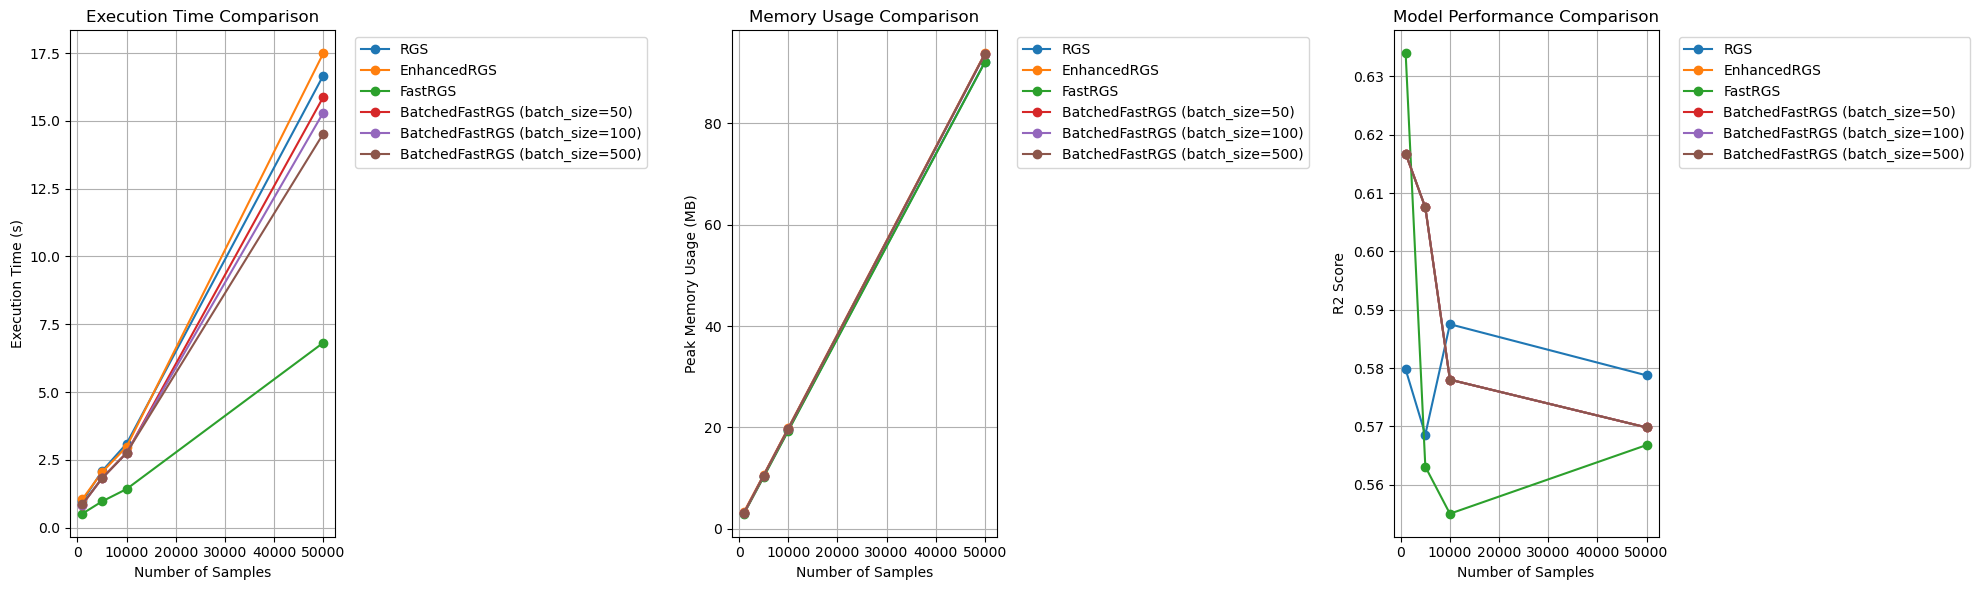


Detailed Results:
                 implementation  n_samples  execution_time  peak_memory_mb  r2_score
                            RGS       1000        0.971480        3.110303  0.579756
                    EnhancedRGS       1000        1.052996        3.310161  0.616773
                        FastRGS       1000        0.517945        2.944813  0.633961
 BatchedFastRGS (batch_size=50)       1000        0.855912        3.083661  0.616773
BatchedFastRGS (batch_size=100)       1000        0.854886        3.083202  0.616773
BatchedFastRGS (batch_size=500)       1000        0.869342        3.083258  0.616773
                            RGS       5000        2.087136       10.345695  0.568598
                    EnhancedRGS       5000        2.046259       10.624907  0.607528
                        FastRGS       5000        0.969522       10.190443  0.563084
 BatchedFastRGS (batch_size=50)       5000        1.831382       10.487166  0.607528
BatchedFastRGS (batch_size=100)       5000    

In [6]:
import numpy as np
import pandas as pd
import time
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from functools import wraps
import tracemalloc

def measure_time_and_memory(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        # Start memory tracking
        tracemalloc.start()
        
        # Time measurement
        start_time = time.time()
        result = func(*args, **kwargs)
        execution_time = time.time() - start_time
        
        # Memory measurement
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        return result, execution_time, peak / 1024 / 1024  # Convert to MB
    return wrapper

@measure_time_and_memory
def run_rgs_variant(model_class, X, y, **kwargs):
    """Run an RGS variant and return fitted model with metrics."""
    model = model_class(**kwargs)
    model.fit(X, y)
    return model

def generate_synthetic_data(n_samples, n_features, noise=0.1, random_state=42):
    """Generate synthetic regression data."""
    X, y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        noise=noise,
        random_state=random_state
    )
    return X, y

def compare_implementations(implementations, dataset_sizes, n_features=100, batch_sizes=[50, 100, 500]):
    """Compare different RGS implementations across various dataset sizes and configurations."""
    results = []
    
    for n_samples in dataset_sizes:
        print(f"\nTesting with {n_samples} samples and {n_features} features")
        
        # Generate data
        X, y = generate_synthetic_data(n_samples, n_features)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Common parameters for all implementations
        base_params = {
            'k_max': 5,
            'm': 10,
            'n_resample_iter': 7,  # Set resampling iterations to 7
            'random_state': 42
        }
        
        for impl_name, impl_class in implementations.items():
            print(f"\nTesting {impl_name}")
            
            # Test different batch sizes for BatchedFastRGS
            if impl_name == 'BatchedFastRGS':
                for batch_size in batch_sizes:
                    try:
                        params = {**base_params, 'batch_size': batch_size}
                        if hasattr(impl_class, 'n_estimators'):
                            params['n_estimators'] = 1000
                        else:
                            params['n_estimators'] = 1000
                            
                        model, exec_time, peak_memory = run_rgs_variant(
                            impl_class,
                            X_train,
                            y_train,
                            **params
                        )
                        y_pred = model.predict(X_test)
                        r2 = r2_score(y_test, y_pred)
                        
                        results.append({
                            'implementation': f'{impl_name} (batch_size={batch_size})',
                            'n_samples': n_samples,
                            'execution_time': exec_time,
                            'peak_memory_mb': peak_memory,
                            'r2_score': r2
                        })
                        
                        print(f"Batch size {batch_size}:")
                        print(f"  Time: {exec_time:.2f}s")
                        print(f"  Memory: {peak_memory:.2f}MB")
                        print(f"  R2 Score: {r2:.4f}")
                        
                    except Exception as e:
                        print(f"Error with {impl_name} (batch_size={batch_size}):")
                        print(str(e))
            else:
                try:
                    params = base_params.copy()
                    if hasattr(impl_class, 'n_estimators'):
                        params['n_estimators'] = 1000
                    else:
                        params['n_estimators'] = 1000
                        
                    model, exec_time, peak_memory = run_rgs_variant(
                        impl_class,
                        X_train,
                        y_train,
                        **params
                    )
                    y_pred = model.predict(X_test)
                    r2 = r2_score(y_test, y_pred)
                    
                    results.append({
                        'implementation': impl_name,
                        'n_samples': n_samples,
                        'execution_time': exec_time,
                        'peak_memory_mb': peak_memory,
                        'r2_score': r2
                    })
                    
                    print(f"Time: {exec_time:.2f}s")
                    print(f"Memory: {peak_memory:.2f}MB")
                    print(f"R2 Score: {r2:.4f}")
                    
                except Exception as e:
                    print(f"Error with {impl_name}:")
                    print(str(e))
    
    return pd.DataFrame(results)

def plot_benchmark_results(results):
    """Plot benchmark results."""
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot execution time
    for impl in results['implementation'].unique():
        impl_data = results[results['implementation'] == impl]
        ax1.plot(impl_data['n_samples'], impl_data['execution_time'], 
                marker='o', label=impl)
    ax1.set_xlabel('Number of Samples')
    ax1.set_ylabel('Execution Time (s)')
    ax1.set_title('Execution Time Comparison')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True)
    
    # Plot memory usage
    for impl in results['implementation'].unique():
        impl_data = results[results['implementation'] == impl]
        ax2.plot(impl_data['n_samples'], impl_data['peak_memory_mb'], 
                marker='o', label=impl)
    ax2.set_xlabel('Number of Samples')
    ax2.set_ylabel('Peak Memory Usage (MB)')
    ax2.set_title('Memory Usage Comparison')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True)
    
    # Plot R2 scores
    for impl in results['implementation'].unique():
        impl_data = results[results['implementation'] == impl]
        ax3.plot(impl_data['n_samples'], impl_data['r2_score'], 
                marker='o', label=impl)
    ax3.set_xlabel('Number of Samples')
    ax3.set_ylabel('R2 Score')
    ax3.set_title('Model Performance Comparison')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True)
    
    plt.tight_layout()
    return fig

# Example usage
if __name__ == "__main__":
    
    # Define implementations to test
    implementations = {
        'RGS': RGS,
        'EnhancedRGS': EnhancedRGS,
        'FastRGS': FastRandomizedGreedySelection,
        'BatchedFastRGS': BatchedFastRGS
    }
    
    # Define dataset sizes to test
    dataset_sizes = [1000, 5000, 10000, 50000]
    
    # Run benchmarks
    results = compare_implementations(implementations, dataset_sizes)
    
    # Plot results
    fig = plot_benchmark_results(results)
    plt.show()
    
    # Print detailed results
    print("\nDetailed Results:")
    pd.set_option('display.max_rows', None)
    print(results.to_string(index=False))

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, confusion_matrix
import numpy as np

# First, let's create our weighted error scoring function
def weighted_error_score(y_true, y_pred, error_costs):
    """
    Calculate weighted error where different misclassifications have different costs
    """
    total_cost = 0
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            error_type = (y_true[i], y_pred[i])
            total_cost += error_costs.get(error_type, 1.0)
            
    return total_cost / len(y_true)

# Create synthetic dataset
X, y = make_classification(
    n_samples=1000, 
    n_features=20,
    n_informative=15,
    n_redundant=5,
    random_state=42
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define error costs
error_costs = {
    (1, 0): 10.0,  # False negative cost
    (0, 1): 2.0,   # False positive cost
}

# Create the custom scorer
custom_scorer = make_scorer(
    weighted_error_score,
    greater_is_better=False,
    error_costs=error_costs
)

# Test with cross validation
rf = RandomForestClassifier(random_state=42)
cv_scores = cross_val_score(
    rf, 
    X_train, 
    y_train, 
    scoring=custom_scorer,
    cv=5
)
print("\nCross-validation scores:")
print(f"Mean: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Test with GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring=custom_scorer,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Print GridSearch results
print("\nGrid Search Results:")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.3f}")

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Calculate weighted error on test set
test_score = weighted_error_score(y_test, y_pred, error_costs)
print(f"\nWeighted Error on Test Set: {test_score:.3f}")

# Compare with standard metrics for reference
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("\nStandard Metrics on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")

# Optional: Look at some detailed results from GridSearchCV
print("\nDetailed Grid Search Results:")
for mean_score, params in zip(grid_search.cv_results_['mean_test_score'],
                            grid_search.cv_results_['params']):
    print(f"Mean Score: {-mean_score:.3f} for {params}")  # Note: scores are negative because greater_is_better=False


Cross-validation scores:
Mean: -0.520 (+/- 0.421)

Grid Search Results:
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best score: -0.520

Confusion Matrix:
[[94 12]
 [ 8 86]]

Weighted Error on Test Set: 0.520

Standard Metrics on Test Set:
Accuracy: 0.900
Precision: 0.878
Recall: 0.915

Detailed Grid Search Results:
Mean Score: 0.565 for {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Mean Score: 0.520 for {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Mean Score: 0.605 for {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
Mean Score: 0.600 for {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Mean Score: 0.562 for {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Mean Score: 0.537 for {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Mean Score: 0.570 for {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}
Mean Score: 0.597 for {'max_depth': 10, 'min_

In [1]:
import numpy as np

class MockModel:
    def __init__(self):
        self.k_max = 3
        self.m_grid = [1, 2, 3]
        self.cv_scores_ = {}
        
        # Initialize scores dictionary - creating a scenario where:
        # - For k=1: m=2 is best
        # - For k=2: m=3 is best
        # - For k=3: m=1 is best
        # And overall k=2, m=3 should be selected as best params
        self.cv_scores_ = {
            1: {
                1: [0.5],
                2: [0.7],  # Best for k=1
                3: [0.6]
            },
            2: {
                1: [0.6],
                2: [0.7],
                3: [0.8]   # Best overall
            },
            3: {
                1: [0.75], # Best for k=3
                2: [0.65],
                3: [0.55]
            }
        }
        
    def find_best_params(self):
        # Find best parameters
        best_params = {}
        for k in range(1, self.k_max + 1):
            mean_scores = {m: np.mean(self.cv_scores_[k][m]) for m in self.m_grid}
            best_m = max(mean_scores.items(), key=lambda x: x[1])[0]
            best_params[k] = {'m': best_m, 'score': mean_scores[best_m]}
        
        # Find optimal k
        self.k_ = max(best_params.items(), key=lambda x: x[1]['score'])[0]
        self.m_ = best_params[self.k_]['m']
        
        return self.k_, self.m_

def test_parameter_selection():
    # Create model with mock scores
    model = MockModel()
    
    # Get best parameters
    best_k, best_m = model.find_best_params()
    
    # Print all scores for inspection
    print("\nScores for each (k, m) combination:")
    for k in range(1, model.k_max + 1):
        for m in model.m_grid:
            score = model.cv_scores_[k][m][0]
            print(f"k={k}, m={m}: score={score}")
    
    print(f"\nSelected best parameters: k={best_k}, m={best_m}")
    
    # Verify we got the expected best parameters
    expected_k, expected_m = 2, 3  # Based on our mock data setup
    assert best_k == expected_k, f"Expected k={expected_k}, got k={best_k}"
    assert best_m == expected_m, f"Expected m={expected_m}, got m={best_m}"
    
    # Verify this actually gives the highest score
    best_score = model.cv_scores_[best_k][best_m][0]
    for k in range(1, model.k_max + 1):
        for m in model.m_grid:
            current_score = model.cv_scores_[k][m][0]
            assert best_score >= current_score, \
                f"Found better score {current_score} at k={k}, m={m} than selected best {best_score}"
    
    print("\nAll tests passed! Parameter selection is working correctly.")

if __name__ == "__main__":
    test_parameter_selection()


Scores for each (k, m) combination:
k=1, m=1: score=0.5
k=1, m=2: score=0.7
k=1, m=3: score=0.6
k=2, m=1: score=0.6
k=2, m=2: score=0.7
k=2, m=3: score=0.8
k=3, m=1: score=0.75
k=3, m=2: score=0.65
k=3, m=3: score=0.55

Selected best parameters: k=2, m=3

All tests passed! Parameter selection is working correctly.
